In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──

✔ dplyr     1.1.0     ✔ readr     2.1.4

✔ forcats   1.0.0     ✔ stringr   1.5.0

✔ ggplot2   3.4.1     ✔ tibble    3.1.8

✔ lubridate 1.9.2     ✔ tidyr     1.3.0

✔ purrr     1.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──

✖ dplyr::filter() masks stats::filter()

✖ dplyr::lag()    masks stats::lag()

ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


character(0)

## Tutorial de Modelos de Regresión con Splines
En este tutorial conocerás cómo crear tres modelos de regresión con splines, particularmente: TPS, MARS y GAM. El objetivo es el generar estos tres modelos para poder seleccionar el que mejor desempeño posea para el pronóstico. Este tutorial está así, dividido en dos grandes secciones, comprendida por una primera de Datos y Modelamiento, que comprende todos los pasos de preprocesamiento hasta la generación de features, la aplicación de los modelos de regresión, la consolidación de resultados, predicciones en la sección de datos de prueba y selección del modelo. La segunda parte está enfocada a la generación de pronósticos adelante o forward, dode emplearemos la paquetería de ModelTime.

**Contenido**
1. [Datos y Modelamiento:](#1)
 1. [Datos: Preprocesamiento](#2)
       1. [Importación de librerías requeridas](#3)
       1. [Descarga de datos financieros](#4)
       1. [Visualización de serie de interés](#5)
       1. [Generación de formato Indexado a fechas](#6)
       1. [Partición de datos de entrenamiento y prueba](#7)
       1. [Generación de features o rezagos y obtención base datos](#8)
 1. [Modelos de regresión](#9)
       1. [Modelo TPS](#10)
       1. [Modelo MARS](#11)
       1. [Modelo GAM](#12)
   1. [Consolidación de los resultados y visualización](#12A)
   1. [Predicciones: fase de prueba](#13A)
   1. [Selección del modelo](#13)
1. [Pronóstico futuro o forward](#14)
  1. [Importación de librerías requeridas](#15)
  1. [Partición de datos de entrenamiento y prueba](#16)
  1. [Desarrollo del modelo MARS](#17)
  1. [Adición del modelo ajustado a ModelTable](#19)
  1. [Proceso de calibración](#20)
  1. [Pronóstico conjunto de prueba & Evaluación de la precisión](#21)
  1. [Pronóstico hacia adelante](#22)

Esto es, en la primera parte aprenderemos a generar un modelo de regresión tipo splines en la sección de datos de entrenamiento para así, seleccionar el que mejor se desempeñe en el conjunto de datos de prueba. 
En la segunda parte,aprenderemos a generar pronósticos futuros. Para ello, aplicaremos la librería ModelTime que permite realizar este proceso.


<a id="1"></a> <br>
## 1. Datos y Modelamiento

<a id="2"></a> <br>
#### A. Datos: Preprocesamiento

Esta sección básicamente involucra desde la descarga de los datos financieros y eliminación de datos faltantes, su visualización, adecuado formato de series de tiempo, así como la partición en la sección de entrenamiento y prueba; que son procesos necesarios previos al modelamiento.

<a id="3"></a> <br>
##### a. Importación de librerías requeridas

A continuación, importaremos las librerías necesarias. Estos paquetes comprenden aquellos para la descarga y manipulación de datos financieros, para la visualización y el modelamiento. En la segunda parte de este tutorial, llamaremos otras librerías que serán útiles para el pronóstico futuro.

In [1]:
### Para el modelado
library(earth)
library(mgcv)
library(caret)     # para optimizar proceso de tunning

#Otros de manipulación de datos
library(tseries)  #manipulación series de tiempo
library(tsfeatures) # Obtención de features relevantes
library(tidyverse) #Data manipulation
library(fields)  #Data manipulation
library(forecast)  # para función pronosticos
library(quantmod) #Para obtener datos financiera
library(dygraphs)  # data visualization
library(dplyr)    # data wrangling
library(ggplot2)  # gráficos 
theme_set(theme_bw())
options(warn = - 1) 

Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix

Loading required package: TeachingDemos

Loading required package: nlme

This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks nlme::collapse()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ purrr::lift()     masks caret::lift()
✖ caret::progress() masks httr::progress()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) 

<a id="4"></a> <br>
##### b. Descarga de datos financieros

Veremos que la obtención de datos financieros lo realizaremos a través de la función GetSymbols(), la cuál accede a diferentes bases de datos. Una de estas bases es yahoo finance (https://es.finance.yahoo.com/) o la base de datos económicos de la Fred (https://fred.stlouisfed.org/). Por el momento, emplearemos la fuente de datos de yahoo finance.

Como parte de los parámetros de la función de GetSymbols(), están el símbolo o "ticker" que identifica el activo financiero y el otro, es la definición de la fecha de consulta. Si omitimos la fecha de consulta definido por una fecha de inicio y otra de término, la función descargará todos los datos históricos que tenga reporte. En nuestro ejemplo, especificaremos unas fechas particulares de inicio y terminación de análisis. Crearemos una función llamada precios, que nos ayudará a automatizar en un futuro, la descarga de los datos. 
Como parte de esta función, omitiremos los datos faltantes e indicaremos que los resultados se carguen en un espacio llamado GlobalEnv, que es básicamente un espacio virtual.

In [2]:
###Función para obtener datos:
start<-format(as.Date("2014-01-01"),"%Y-%m-%d")
end<-format(as.Date("2021-06-30"),"%Y-%m-%d")

precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre 4:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}


In [3]:
##Llamar el activo de interés, pueden ser varios:
precios("AMZN")

<a id="5"></a> <br>
##### c. Visualización de serie de interés

Para la visualización, juntamos las series mediante la función xts, ya que las series poseen ese formato. Posteriormente y a través de la función dygraphs(), podemos generar una visualización dinámica, que permite cambiar la ventana de análisis, dentro de las fechas antes especificadas.

In [16]:
##Juntar los datos y renombrarlos:
Pr<-merge.xts(AMZN) %>% na.omit()
head(Pr)
colnames(Pr) <- c("Amzn")
head(Pr)
##Serie tiempo, grafica interactiva
Precios<- dygraph(Pr[,c(1)], main="Precios ") %>%
  dyAxis("y", label = "Precios") %>%
  dyRangeSelector(dateWindow = c("2014-01-01", "2021-07-30"))%>%
  dyOptions(colors = RColorBrewer::brewer.pal(4,"Set1"))
Precios

           AMZN.Close
2014-01-02    19.8985
2014-01-03    19.8220
2014-01-06    19.6815
2014-01-07    19.9015
2014-01-08    20.0960
2014-01-09    20.0505

              Amzn
2014-01-02 19.8985
2014-01-03 19.8220
2014-01-06 19.6815
2014-01-07 19.9015
2014-01-08 20.0960
2014-01-09 20.0505

HTML widgets cannot be represented in plain text (need html)

In [17]:
# Podemos ver los 5 ultimos datos redondeando hasta 3 decimales:
round(head(Pr, n = 5), 3)

             Amzn
2014-01-02 19.898
2014-01-03 19.822
2014-01-06 19.681
2014-01-07 19.902
2014-01-08 20.096

<a id="6"></a> <br>
##### d. Generación de formato Indexado a fechas

Un paso usual en el procesamiento de las series de tiempo, es el cambio de formatos de las mismas, especialmente en un formato que nos permita manipular las fechas. Por ello, cambiaremos el tipo de formato de la fecha hacia uno tipo zoo, que nos permitirá generar operaciones involucrando las fechas.

In [18]:
##Index format.
xpr <- as.xts(Pr, dateFormat = "Date")
Pr_index <- fortify.zoo(xpr)
head(Pr_index)
nrow(Pr)

Index      Amzn   
1 2014-01-02 19.8985
2 2014-01-03 19.8220
3 2014-01-06 19.6815
4 2014-01-07 19.9015
5 2014-01-08 20.0960
6 2014-01-09 20.0505

[1] 1886

<a id="7"></a> <br>
##### e. Partición de datos de entrenamiento y prueba

Ya sabiendo la longitud de la serie a través de la función nrow(), podemos partir la serie. Una proporción usual es desde el 80/20 o menos. Tomemos esa referencia donde dejamos el 4% a la prueba.

In [19]:
#Partimos serie para train & test
h <- round(length(Pr)*0.04, digits = 0 )
h
Pr_tra <- Pr[1:(nrow(Pr) - h), ]
Pr_tes<- Pr[(nrow(Pr) - h + 1):nrow(Pr), ]


[1] 75

In [20]:
#Pasamos a formato data frame para poder generar los retrasos
Pr_df_tra<-as.data.frame(Pr_tra)
head(Pr_df_tra)
str(Pr_df_tra)

Amzn   
2014-01-02 19.8985
2014-01-03 19.8220
2014-01-06 19.6815
2014-01-07 19.9015
2014-01-08 20.0960
2014-01-09 20.0505

'data.frame':	1811 obs. of  1 variable:
 $ Amzn: num  19.9 19.8 19.7 19.9 20.1 ...


<a id="8"></a> <br>
##### f. Generación de features o rezagos y obtención base datos

Una de las características de los modelos supervisados es que requieren aprender de un conjunto de datos de entrenamiento, los cuales se caracterizan por representar los features o variables más relevantes que pueden explicar la respuesta. Para ello entonces y a diferencia de los datos tipo tabulares, los features conforman los componentes de las series. Es decir, los rezagos que muestren una correlación en el tiempo incluyendo aquellos estacionales y la tendencia.

Exiten varios métodos para conocer estos features. Una de ellas es mediante los gráficos de PACF que demuestran los rezagos más correlacionados, una vez la serie es estacionaria. Para hacerla estacionaria, se plican diferenciaciones a las series y posteriormente, se aplican la función pacf() a la serie para observar los rezagos. Otra manera de conocer los features, es mediante la función tsfeatures de la misma librería. En el caso de este tutorial, por simplicidad aplicaremos los primeros 4 rezagos como features relevantes, así como el componente de tendencia.

Por ello, el siguiente paso es la generación de los retrasos y la tendencia.

frequency nperiods seasonal_period trend    spike        linearity curvature
1 1         0        1               0.992363 1.235517e-10 39.93092  10.32339 
  e_acf1    e_acf10 entropy    x_acf1    x_acf10  diff1_acf1  diff1_acf10
1 0.9155322 4.38811 0.04595032 0.9978648 9.783311 -0.06026918 0.02881654 
  diff2_acf1 diff2_acf10
1 -0.5313319 0.3505822

x_pacf5 diff1x_pacf5 diff2x_pacf5 
  0.99737948   0.01192953   0.52443021

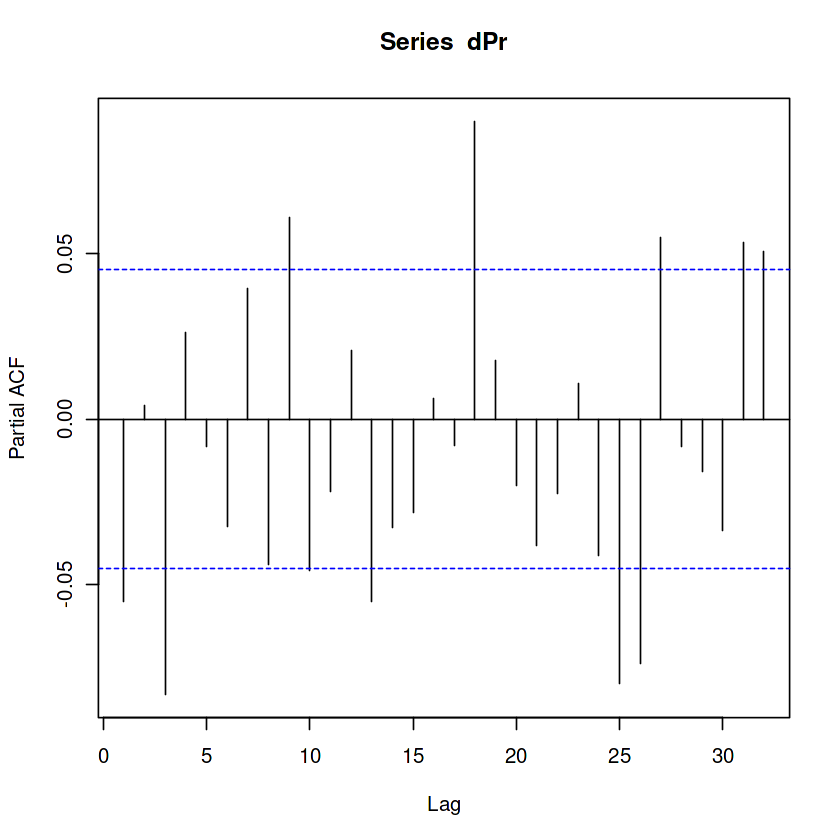

In [32]:
#Obteneomos features:
tsfeatures(Pr_df_tra$Amzn)
pacf_features(Pr_df_tra$Amzn)
#Visualiamos los rezagos autorregresivos, haciendo estacionaria la serie:
dPr<-diff(Pr_df_tra)%>% na.omit() # Train section.
pacf(dPr)

Como podemos observar, no hay una estacionalidad definida (frecuencia y seasonal period son uno), la tendencia es relevante (valor cercano a uno), los features acf se modelan usualmente con modelos MA (moving average). Esos features nos dicen el primer valor de la autocorrelacón al primer rezago y el x_acf10 la suma de los cuadrados de los primeros 10 rezagos. Los otros, "diff1_" el valor de las ACF con las series diferenciadas una o dos veces, según corresponda. Los demás features nos dan idea de la linealidad y la facilidad de pronosticabilidad.

En nuestro caso, podemos ver que los rezagos 1,3 y otros posteriores, como el 9 son significativos, así como la tendencia. Por facilidad, tomaremos los primeros cuatro, más el componente de tendencia como features.

In [33]:
#Generamos retrasos
lag_pr = lag(Pr_df_tra,n=1L) 
lag2_pr = lag(Pr_df_tra,n=2L) 
lag3_pr = lag(Pr_df_tra,n=3L)
lag4_pr = lag(Pr_df_tra,n=4L)

In [34]:
#Unimos los nuevos features o retrasos en una base
Pr_all_train<-cbind(Pr_df_tra, lag_pr, lag2_pr, lag3_pr, lag4_pr) %>%na.omit()
colnames(Pr_all_train)<-c("Amzn","l1","l2","l3","l4")
head(Pr_all_train)

Amzn    l1      l2      l3      l4     
2014-01-08 20.0960 19.9015 19.6815 19.8220 19.8985
2014-01-09 20.0505 20.0960 19.9015 19.6815 19.8220
2014-01-10 19.8830 20.0505 20.0960 19.9015 19.6815
2014-01-13 19.5490 19.8830 20.0505 20.0960 19.9015
2014-01-14 19.8770 19.5490 19.8830 20.0505 20.0960
2014-01-15 19.7935 19.8770 19.5490 19.8830 20.0505

In [35]:
Pr_all_train$trend = 1:nrow(Pr_all_train)
str(Pr_all_train)
head(Pr_all_train)
tail(Pr_all_train)

'data.frame':	1807 obs. of  6 variables:
 $ Amzn : num  20.1 20.1 19.9 19.5 19.9 ...
 $ l1   : num  19.9 20.1 20.1 19.9 19.5 ...
 $ l2   : num  19.7 19.9 20.1 20.1 19.9 ...
 $ l3   : num  19.8 19.7 19.9 20.1 20.1 ...
 $ l4   : num  19.9 19.8 19.7 19.9 20.1 ...
 $ trend: int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "na.action")= 'omit' Named int [1:4] 1 2 3 4
  ..- attr(*, "names")= chr [1:4] "2014-01-02" "2014-01-03" "2014-01-06" "2014-01-07"


Amzn    l1      l2      l3      l4      trend
2014-01-08 20.0960 19.9015 19.6815 19.8220 19.8985 1    
2014-01-09 20.0505 20.0960 19.9015 19.6815 19.8220 2    
2014-01-10 19.8830 20.0505 20.0960 19.9015 19.6815 3    
2014-01-13 19.5490 19.8830 20.0505 20.0960 19.9015 4    
2014-01-14 19.8770 19.5490 19.8830 20.0505 20.0960 5    
2014-01-15 19.7935 19.8770 19.5490 19.8830 20.0505 6

Amzn     l1       l2       l3       l4       trend
2021-03-05 150.0230 148.8785 150.2500 154.7265 157.3070 1802 
2021-03-08 147.5975 150.0230 148.8785 150.2500 154.7265 1803 
2021-03-09 153.1425 147.5975 150.0230 148.8785 150.2500 1804 
2021-03-10 152.8820 153.1425 147.5975 150.0230 148.8785 1805 
2021-03-11 155.6795 152.8820 153.1425 147.5975 150.0230 1806 
2021-03-12 154.4745 155.6795 152.8820 153.1425 147.5975 1807

In [36]:
#Separamos objetos para las secciones de entrenamiento con todos los features X_train:
x_train <- Pr_all_train %>% 
  select(starts_with(c("l", "t")))
head(x_train)

l1      l2      l3      l4      trend
2014-01-08 19.9015 19.6815 19.8220 19.8985 1    
2014-01-09 20.0960 19.9015 19.6815 19.8220 2    
2014-01-10 20.0505 20.0960 19.9015 19.6815 3    
2014-01-13 19.8830 20.0505 20.0960 19.9015 4    
2014-01-14 19.5490 19.8830 20.0505 20.0960 5    
2014-01-15 19.8770 19.5490 19.8830 20.0505 6

In [37]:
#Igual para la respuesta y_train:
y_train <- Pr_all_train %>% 
  select(Amzn)
head(y_train)

Amzn   
2014-01-08 20.0960
2014-01-09 20.0505
2014-01-10 19.8830
2014-01-13 19.5490
2014-01-14 19.8770
2014-01-15 19.7935

Hasta este paso, ya contamos con los datos en las secciones útiles para la parte de entrenamiento; donde hemos separado la respuesta y generados los rezagos que son los features a nuestro modelo de regresión.

Ahora, podemos proceder a aplicar los modelos de splines, como se muestra a continuación.

<a id="9"></a> <br>
### B. Modelos de Regresión

Ya con el conjunto de datos de entrenamiento divididos en el conjunto de features o "x_train" y "y_train", procederemos a aplicar lso modelos en el siguiente orden.
1) TPS
2) MARS
3) GAM

<a id="10"></a> <br>
##### a. Modelo TPS

Modelo thin plate spline.

Observar que el orden de especificación en este modelo, es primero los regresores y despues la respuesta, a diferencia de la mayoría de la mayoría de modelos tales como lm().
Para ver acerca del código de tps() en R: https://www.rdocumentation.org/packages/fields/versions/13.3/topics/Tps 

In [38]:
#1) Tps: Thin Plate Spline Regression
tps_mod <- Tps(x_train, y_train)

In [46]:
# Podemos ver los primero valores del ajuste:
head(tps_mod$fitted.values)

Amzn    
[1,] 20.07305
[2,] 20.05230
[3,] 19.88480
[4,] 19.58787
[5,] 19.85291
[6,] 19.81462

<a id="11"></a> <br>
##### b. Modelo MARS

procedemos con el modelo de MARS, donde la función se asemeja a la captura de los modelos de regresión lineal: ingreamos la respuesta, seguido de los regresores o features. El método de pruning o "pmethod" se puede especificar como "backward" que es el default, u otros, como "exhaustive", si el modelo incluye más de 30 términos. 

In [40]:
#2) MARS
mars_mod <- earth(
  Amzn ~ ., data=Pr_all_train, pmethod="backward" )

In [41]:
# Podemos ver el resultado del modelo:
print(mars_mod)

Selected 3 of 3 terms, and 1 of 5 predictors
Termination condition: RSq changed by less than 0.001 at 3 terms
Importance: l1, l2-unused, l3-unused, l4-unused, trend-unused
Number of terms at each degree of interaction: 1 2 (additive model)
GCV 2.400054    RSS 4312.93    GRSq 0.9987269    RSq 0.9987325


En este modelo, podemos ver que se seleccionaron 3 de 3 términos, esos son, la ordenada al origen, mas dos splines que de manera general, ajusta a toda la serie; es decir, todas las funciones splines son de orden lineal. También, que de los 4 features o rezagos, sólo se uso el primero. Podemos tambien ver los métricos de error como el Generalized Cross Validation, el RSS y demás.

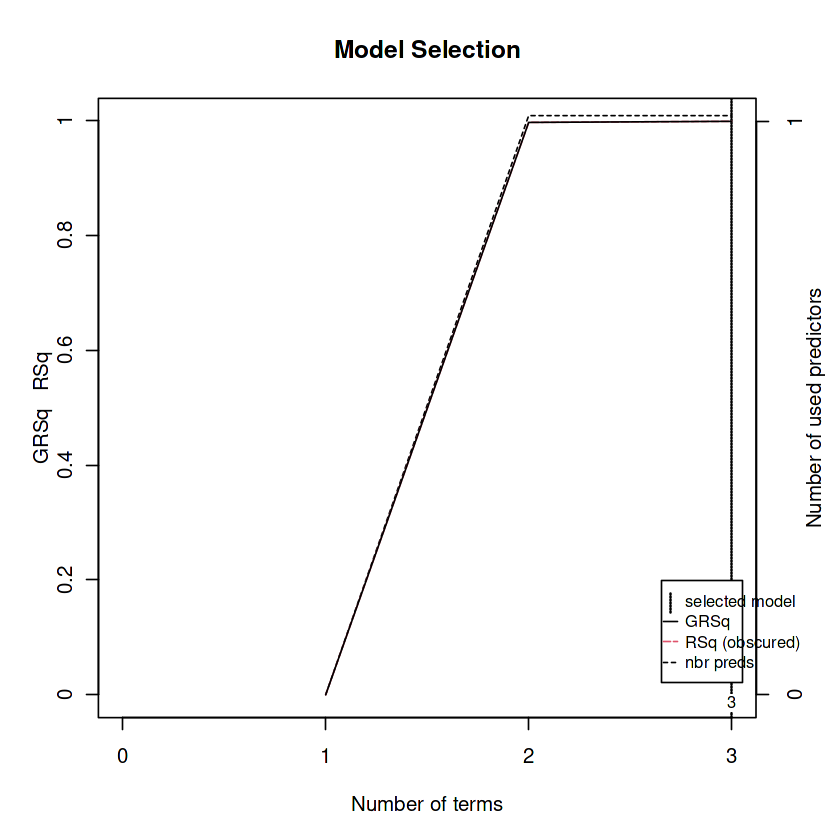

In [42]:
plot(mars_mod, which = 1)

De manera complementaria al resultado anterior, en esta gráfica lo que nos muestra es que tenemos el número de términos y cómo se llega al número óptimo de éstos en 3, que es donde una línea vertical en 3, cruza con la línea de selected modelo. Del lado derecho, nos indica que el número de predictores o rezagos empleados es de 1.

<a id="12"></a> <br>
##### c. Modelo GAM
Para el modelo de GAM, se especifican los features de manera particular, a través de s(), que refiere una función de suavizamiento o "smooth". el método "REML" refiere el método de estimación del parámetro de suavizamiento.

In [47]:
#GAM
gam_mod <- gam(
  Amzn ~ s(l1) + s(l2) + 
    s(l3) + s(l4)+s(trend),
  data = Pr_all_train,
  method = "REML")
summary(gam_mod)


Family: gaussian 
Link function: identity 

Formula:
Amzn ~ s(l1) + s(l2) + s(l3) + s(l4) + s(trend)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 64.09840    0.03575    1793   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
           edf Ref.df       F p-value    
s(l1)    2.156  2.678 505.332 < 2e-16 ***
s(l2)    3.819  4.531   1.760 0.09653 .  
s(l3)    3.797  4.429   1.354 0.14775    
s(l4)    5.088  5.876   3.794 0.00124 ** 
s(trend) 1.002  1.004   6.077 0.01364 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.999   Deviance explained = 99.9%
-REML =   3337  Scale est. = 2.3092    n = 1807

SImilar al modelo de MARS, el modelo de GAM nos indica que se emplean los rezagos (l1) y (l4), más un estimador de la ordenada al origen. 

<a id="12A"></a> <br>
##### C. Consolidación de Resultados y Visualización

Podemos reunir en una sola base todos los resultados de los modelos, para facilitar la visualización.

In [48]:
# Unimos las base junto con los resultados de ajuste
Pr_train <- Pr_all_train %>% 
  mutate(
    fitted_tps = fitted(tps_mod)[,1],
    fitted_mars = fitted(mars_mod)[,1],
    fitted_gam = fitted(gam_mod)
  )

head(Pr_train)

Amzn    l1      l2      l3      l4      trend fitted_tps fitted_mars
2014-01-08 20.0960 19.9015 19.6815 19.8220 19.8985 1     20.07305   19.86296   
2014-01-09 20.0505 20.0960 19.9015 19.6815 19.8220 2     20.05230   20.05829   
2014-01-10 19.8830 20.0505 20.0960 19.9015 19.6815 3     19.88480   20.01259   
2014-01-13 19.5490 19.8830 20.0505 20.0960 19.9015 4     19.58787   19.84437   
2014-01-14 19.8770 19.5490 19.8830 20.0505 20.0960 5     19.85291   19.50895   
2014-01-15 19.7935 19.8770 19.5490 19.8830 20.0505 6     19.81462   19.83835   
           fitted_gam
2014-01-08 19.67324  
2014-01-09 19.87037  
2014-01-10 19.82787  
2014-01-13 19.67207  
2014-01-14 19.36418  
2014-01-15 19.65023

In [49]:
#Damos formato de xts para poder manipular los datos y graficarlos con ggplot más adelante
x <- as.xts(Pr_train, dateFormat = "Date")
Pr_train2 <- fortify.zoo(x)
head(Pr_train2)

Index      Amzn    l1      l2      l3      l4      trend fitted_tps
1 2014-01-08 20.0960 19.9015 19.6815 19.8220 19.8985 1     20.07305  
2 2014-01-09 20.0505 20.0960 19.9015 19.6815 19.8220 2     20.05230  
3 2014-01-10 19.8830 20.0505 20.0960 19.9015 19.6815 3     19.88480  
4 2014-01-13 19.5490 19.8830 20.0505 20.0960 19.9015 4     19.58787  
5 2014-01-14 19.8770 19.5490 19.8830 20.0505 20.0960 5     19.85291  
6 2014-01-15 19.7935 19.8770 19.5490 19.8830 20.0505 6     19.81462  
  fitted_mars fitted_gam
1 19.86296    19.67324  
2 20.05829    19.87037  
3 20.01259    19.82787  
4 19.84437    19.67207  
5 19.50895    19.36418  
6 19.83835    19.65023

In [50]:
# Podemos dar formato para que el etiquetado en la visualización sea más sencilla.
Pr_train3 <- Pr_train2 %>% 
  select(Index, Amzn, starts_with("fitted")) %>% 
  gather("model", "value", -Index, -Amzn) %>% 
  mutate(model = str_remove(model, "fitted_"))
tail(Pr_train3)

Index      Amzn     model value   
5416 2021-03-05 150.0230 gam   150.6041
5417 2021-03-08 147.5975 gam   151.8450
5418 2021-03-09 153.1425 gam   149.3167
5419 2021-03-10 152.8820 gam   153.7801
5420 2021-03-11 155.6795 gam   154.1920
5421 2021-03-12 154.4745 gam   155.6031

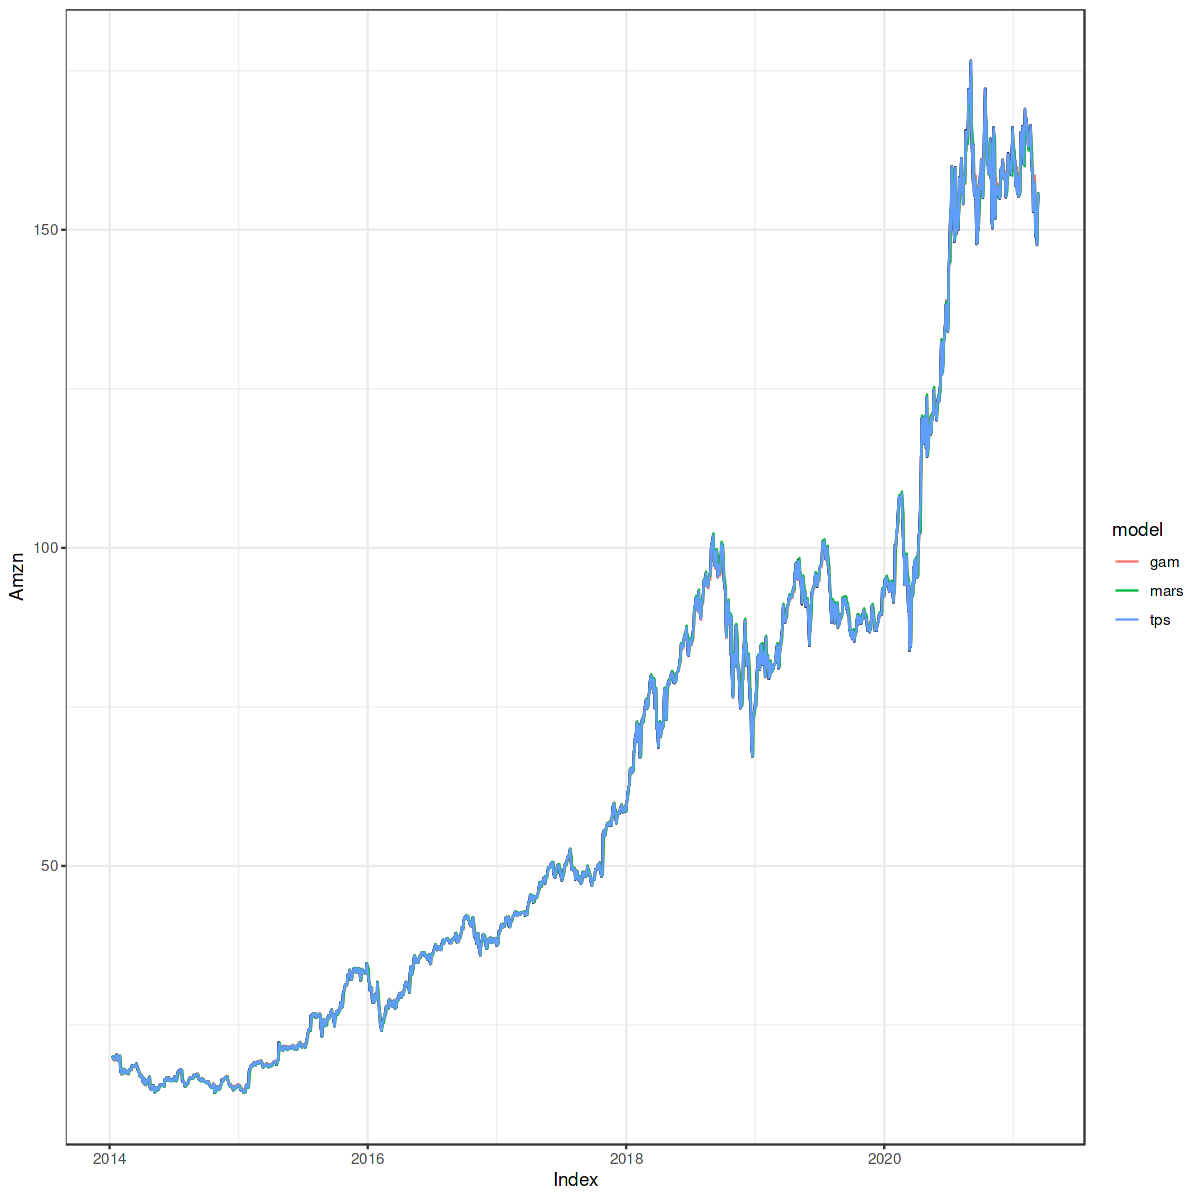

In [51]:
## Graficamos:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(Pr_train3,aes(Index,Amzn))+geom_line() +
geom_line()+
geom_line(aes(y=value, color=model))
#theme(plot.title = element_text(size=30), legend.position="upper", cex=100)

Vemos en el gráfico que todos los modelos generan un excelente ajuste a la serie de entrenamiento. Para la selección, procedemos con la fase de prueba, donde aplicamos el modelo a los datos de prueba, generamos métricos de error de pronóstico, que nos permite generar una selección.

<a id="13A"></a> <br>
##### D. Predicciones: Fase de Prueba

Con los resultados de los modelos, al aplicarlos a los datos de prueba podemos ver el que mejor desempeña. Este sería un proceso de predicción en los datos de prueba o x_test, donde contamos con una y_test.

Para ello, procedemos con la generación de features, como lo hicimos en el inciso f) del tutorial, para el caso de laos datos de entrenamiento. 

In [52]:
#Procedemos con pasar los datos de un formato xts, a un formato data.frame para facilitar la generación de rezagos.
Pr_test2<-as.data.frame(Pr_tes)
#head(Pr_test2)

In [53]:
#Generación de rezagos o features: debemos generar los mismos tipos de features que en la parte de entrenamiento.
lag1_pr_test = lag(Pr_test2,n=1L) 
lag2_pr_test = lag(Pr_test2,n=2L) 
lag3_pr_test = lag(Pr_test2,n=3L) 
lag4_pr_test = lag(Pr_test2,n=4L) 

Pr_all_test<-cbind(Pr_test2, lag1_pr_test, lag2_pr_test, lag3_pr_test, lag4_pr_test) %>%na.omit()
colnames(Pr_all_test)<-c("Amzn","l1","l2","l3","l4")
#Generamos la tendencia:
Pr_all_test$trend = 1:nrow(Pr_all_test)
#Renombramos:
colnames(Pr_all_test)<-c("Amzn","l1","l2","l3","l4", "trend")
dim(Pr_all_test)
head(Pr_all_test)
str(Pr_all_test)

[1] 71  6

Amzn     l1       l2       l3       l4       trend
2021-03-19 153.7480 151.3995 156.7865 154.5930 154.0840 1    
2021-03-22 155.5435 153.7480 151.3995 156.7865 154.5930 2    
2021-03-23 156.8750 155.5435 153.7480 151.3995 156.7865 3    
2021-03-24 154.3535 156.8750 155.5435 153.7480 151.3995 4    
2021-03-25 152.3130 154.3535 156.8750 155.5435 153.7480 5    
2021-03-26 152.6015 152.3130 154.3535 156.8750 155.5435 6

'data.frame':	71 obs. of  6 variables:
 $ Amzn : num  154 156 157 154 152 ...
 $ l1   : num  151 154 156 157 154 ...
 $ l2   : num  157 151 154 156 157 ...
 $ l3   : num  155 157 151 154 156 ...
 $ l4   : num  154 155 157 151 154 ...
 $ trend: int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "na.action")= 'omit' Named int [1:4] 1 2 3 4
  ..- attr(*, "names")= chr [1:4] "2021-03-15" "2021-03-16" "2021-03-17" "2021-03-18"


In [54]:
# Tambien, damos formato indexado a la fecha.
yt <- as.xts(Pr_all_test, dateFormat = "Date")
Pr_test2 <- fortify.zoo(yt)
head(Pr_test2)

Index      Amzn     l1       l2       l3       l4       trend
1 2021-03-19 153.7480 151.3995 156.7865 154.5930 154.0840 1    
2 2021-03-22 155.5435 153.7480 151.3995 156.7865 154.5930 2    
3 2021-03-23 156.8750 155.5435 153.7480 151.3995 156.7865 3    
4 2021-03-24 154.3535 156.8750 155.5435 153.7480 151.3995 4    
5 2021-03-25 152.3130 154.3535 156.8750 155.5435 153.7480 5    
6 2021-03-26 152.6015 152.3130 154.3535 156.8750 155.5435 6

In [55]:
#Neuvamente, podemos crear un objeto que contemple sólamente los rezagos o features de la parte de prueba, este sería el x_test.
x_test <- Pr_test2 %>% 
  select(starts_with(c("l", "t")))
head(x_test)

l1       l2       l3       l4       trend
1 151.3995 156.7865 154.5930 154.0840 1    
2 153.7480 151.3995 156.7865 154.5930 2    
3 155.5435 153.7480 151.3995 156.7865 3    
4 156.8750 155.5435 153.7480 151.3995 4    
5 154.3535 156.8750 155.5435 153.7480 5    
6 152.3130 154.3535 156.8750 155.5435 6

In [56]:
##Llamamos de manera similar, a la respuesta de la parte de prueba.
y_test <- Pr_test2%>% 
  select(Amzn)
dim(y_test)

[1] 71  1

Y generamos las predicciones una vez listos los objetos y_test y x_test:

In [57]:
#Modelo TPS
pred_tps = predict(tps_mod, x_test)

In [58]:
#Modelo MARS
pred_mars = predict(mars_mod, x_test)[,1]
str(pred_mars)

 num [1:71] 152 154 156 157 155 ...


In [59]:
##Modelo GAM
pred_gam=predict(gam_mod, newdata = Pr_test2)
str(pred_gam)

 num [1:71(1d)] 151 152 155 155 153 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:71] "1" "2" "3" "4" ...


Podemos igualmnete aplicar la siguiente función que va a generar tres columnas nuevas con los datos de predicción de cada modelo que facilitará el 
manejo para la visualización, como sustituto de las tres anteriores, pero, debemos saber qué elementos llamar como resultado de cada modelo:

In [60]:
#Podemos unir los resultados a manera que se generen columnas con los resultados de ajuste de los modelos:
Pr_test3 <- Pr_test2 %>% 
  mutate(
    pred_tps = predict(tps_mod, x_test)[,1],
    pred_mars = predict(mars_mod, x_test)[,1],
    pred_gam = predict(gam_mod, newdata = Pr_test2)
    #pred_ets = pred_ets2
  ) 
head(Pr_test3)
str(Pr_test3)

Index      Amzn     l1       l2       l3       l4       trend pred_tps
1 2021-03-19 153.7480 151.3995 156.7865 154.5930 154.0840 1     177.5779
2 2021-03-22 155.5435 153.7480 151.3995 156.7865 154.5930 2     180.5139
3 2021-03-23 156.8750 155.5435 153.7480 151.3995 156.7865 3     187.8040
4 2021-03-24 154.3535 156.8750 155.5435 153.7480 151.3995 4     181.7759
5 2021-03-25 152.3130 154.3535 156.8750 155.5435 153.7480 5     180.0020
6 2021-03-26 152.6015 152.3130 154.3535 156.8750 155.5435 6     179.9003
  pred_mars pred_gam
1 151.9237  150.7919
2 154.1780  152.4812
3 155.7650  155.1646
4 156.9419  155.3542
5 154.7132  153.2159
6 152.8411  151.4075

'data.frame':	71 obs. of  10 variables:
 $ Index    : Date, format: "2021-03-19" "2021-03-22" ...
 $ Amzn     : num  154 156 157 154 152 ...
 $ l1       : num  151 154 156 157 154 ...
 $ l2       : num  157 151 154 156 157 ...
 $ l3       : num  155 157 151 154 156 ...
 $ l4       : num  154 155 157 151 154 ...
 $ trend    : num  1 2 3 4 5 6 7 8 9 10 ...
 $ pred_tps : num  178 181 188 182 180 ...
 $ pred_mars: num  152 154 156 157 155 ...
 $ pred_gam : num [1:71(1d)] 151 152 155 155 153 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ : chr [1:71] "1" "2" "3" "4" ...


Podemos también gerar una visualización de la sección de prueba:

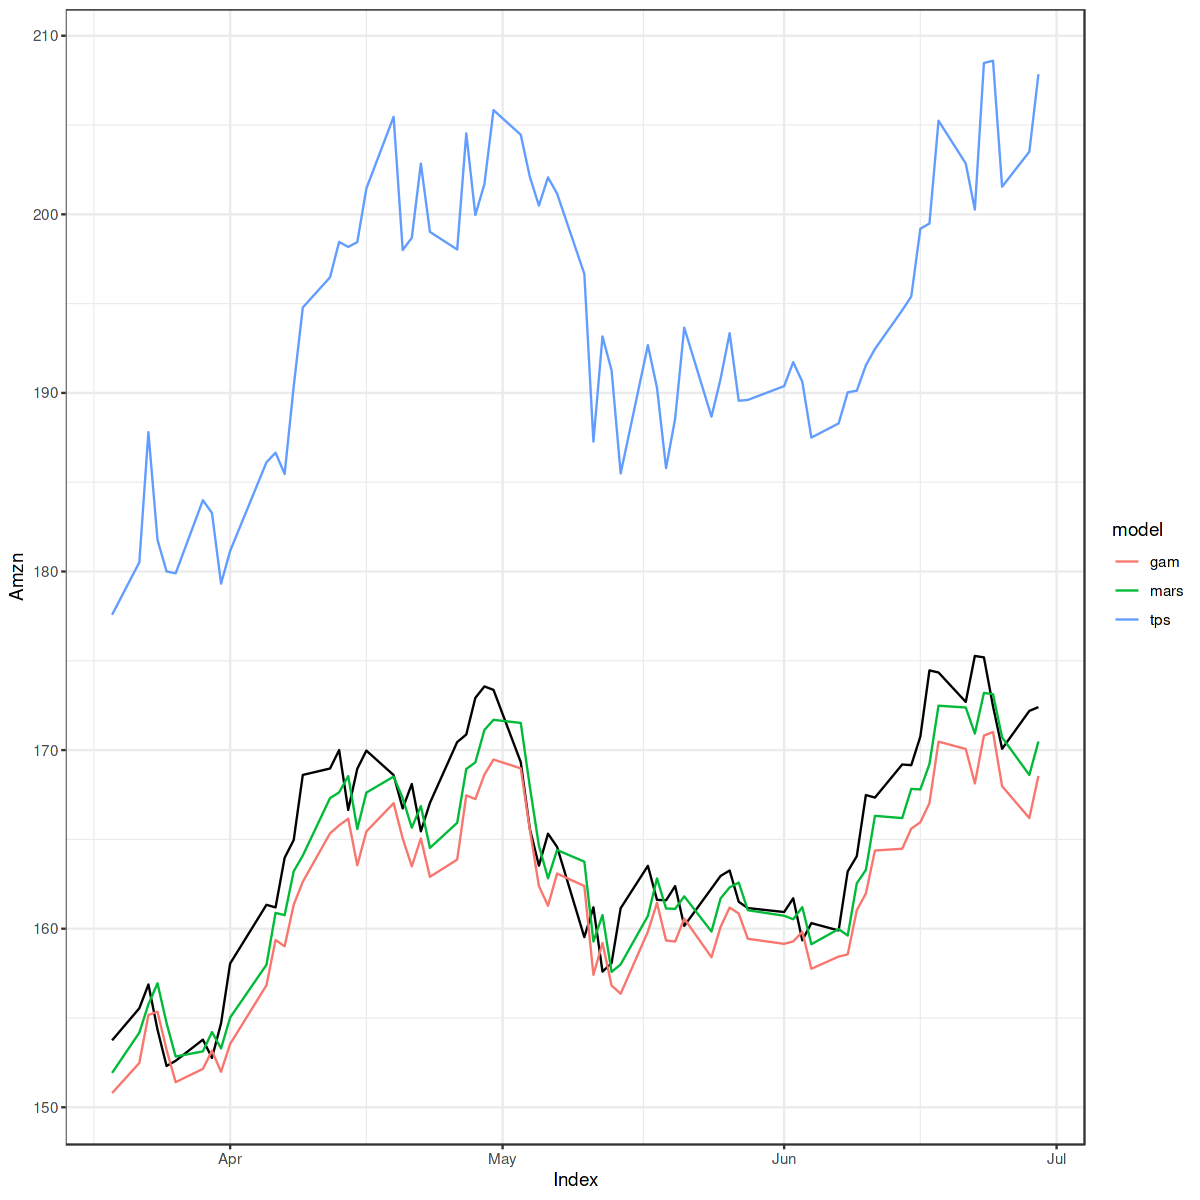

In [61]:
##Podemos graficar sólo el segmento de pronóstico:
Pr_test3 %>% 
  select(Index, Amzn, starts_with("pred")) %>% 
  gather("model", "forecast", -Index, -Amzn) %>% 
  mutate(model = str_remove(model, "pred_")) %>% 
  ggplot(aes(Index, Amzn)) +
  geom_line() +
  geom_line(aes(y = forecast, color = model))

O toda la serie con el pronóstico:

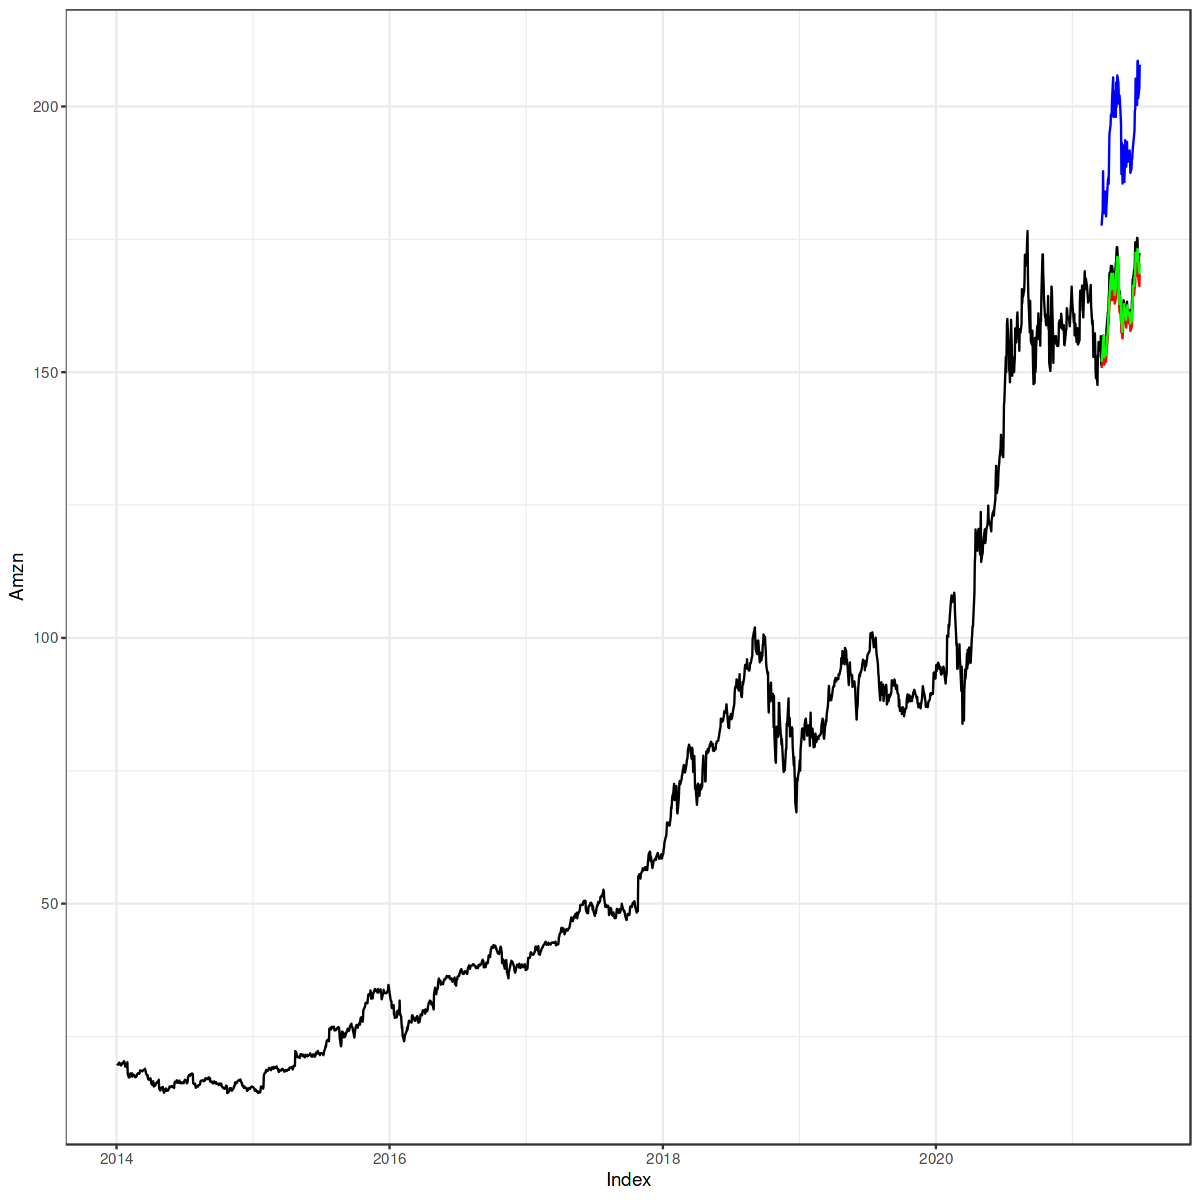

In [62]:
Pr_index %>%
  ggplot(aes(Index, Amzn)) +
  geom_line() +
  geom_line(aes(Index, pred_tps), data = Pr_test3, color = "blue") +
  geom_line(aes(Index, pred_gam), data = Pr_test3, color = "red") +
  geom_line(aes(Index, pred_mars), data = Pr_test3, color = "green")

<a id="13"></a> <br>
##### E. Selección Modelo

En esta sección, determinamos los métricos de error a los resultados de predicción en los datos de prueba para cada modelo. 

In [63]:
# Métricas de desempeño
yardstick::metrics(Pr_test3, truth = Amzn, estimate = pred_gam)
yardstick::metrics(Pr_test3, truth = Amzn, estimate = pred_mars)
yardstick::metrics(Pr_test3, truth = Amzn, estimate = pred_tps)

.metric .estimator .estimate
1 rmse    standard   3.5252808
2 rsq     standard   0.8888325
3 mae     standard   3.0288094

.metric .estimator .estimate
1 rmse    standard   2.3168033
2 rsq     standard   0.8902832
3 mae     standard   1.9612095

.metric .estimator .estimate 
1 rmse    standard   29.6727036
2 rsq     standard    0.7507849
3 mae     standard   29.3988666

Como podemos observar, el mejor desempeño a partir de los resultados del RMSE, es del modelo de MARS. Los demás métricos indican igualmente que el modelo GAM genera un buen pronóstico, similar al MARS. No habiendo una regla genera para la selección de un modelo ante un sólo métrico, usualmente buscamos aquél que muestre de manera general, los menores valores de métricos de error. Seleccionamos así al MARS.

<a id="14"></a> <br>
## 2. Pronostico forward

Hasta ahora, hemos aplicado los modelos de splines a una sección de entrenamiento para generar modelos de regresión a través de TPS, MARS y GAM, donde, a partir de la sección de datos de prueba, hemos identificado que el modelo de MARS, se desempeña mejor para el pronóstico.
Esta información es útil para identificar el mejor modelo, sin embargo, es de nuestro interés conocer valores futuros de la respuesta, en nuestro caso, el precio del activo, dados el modelo de ajuste y los datos pasados.
Este tipo de problemas, generan un enfoque de pronóstico de tipo "hacia adelante", "Futuro" o también "Secuenciales", donde, no contamos con una parte de datos, puesto que no se han generado. Así, existen pocas funciones que cuentan con este tipo de regresión que funciona similar al siguiente enfoque: suponer que tenemos la siguiente serie:
[2, 3, 4, 5, 4, 6, 7, 6, 8, 9]

Ante un pronóstico de 1, se podría generar un esquema de datos de l
a siguiente manera para que el modelo en entrenamiento genere un dato futuro:
* [2, 3, 4] -> [5]
* [3, 4, 5] -> [4]
* [4, 5, 4] -> [6]
* [5, 4, 6] -> [7]
* [4, 6, 7] -> [6]
* [6, 7, 6] -> [8]
* [7, 6, 8] -> [9]

Es decir, el formato especifica que a un determinado día x(t), los features son los valores de x(t-1), x(t-2),... x(t-n) donde n es el rango de retraso a aplicar, para generar el pronóstico a un paso.
Aquí los datos requeridos para el pronóstico son n=3, es decir, toma los tres últimos días de la serie para generar el pronóstico.

Existen librerías que ayudan a generar dicha estructura. Por ejemplo, en Python, está un móodulo de Keras llamado TimeseriesGenerator que genera esta estructura, donde se entrenan los modelos. En el caso particular de este tutorial, se cuenta con la librería de ModelTime [1], que genera tanto el modelo, como el pronóstico futuro.


[1]:https://www.rdocumentation.org/packages/modeltime/versions/1.2.2

Procedamos con los pasos iniciales para poder emplear la paquetería ModelTime.

<a id="15"></a> <br>
##### A. Importación de las librerías requeridas

Para esta sección, volvemos a descargar las paqueterías necesarias.

In [64]:
library(modeltime)


Attaching package: ‘modeltime’


The following object is masked from ‘package:TTR’:

    growth




In [66]:
library(tidyverse)
library(fields)
library(earth)
library(mgcv)
library(forecast)
library(quantmod)
library(xts)
library(dygraphs)
library(dplyr)

theme_set(theme_bw())

In [67]:
library(timetk)
library(tidymodels)

library(tidyverse)
library(lubridate)
library(timetk)
interactive <- TRUE

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ yardstick::accuracy()    masks forecast::accuracy()
✖ dplyr::collapse()        masks nlme::collapse()
✖ scales::discard()        masks purrr::discard()
✖ dplyr::filter()          masks stats::filter()
✖ xts::first()             masks dplyr::first()
✖ recipes::fixed()         masks stringr::fixed()
✖ dplyr::lag()             masks stats::lag()
✖ xts::last()              masks dplyr::last()
✖ purrr::lift()            masks caret::lift()
✖ dials::momentum()        masks TTR::momentum()
✖ yardstick::precision()   masks caret::precision()
✖ yardstick::recall()      masks caret

<a id="16"></a> <br>
##### B. Partición de datos de entrenamiento y prueba

In [68]:
##Para ser coherentes con los datos reservados en la parte 1 de este tutorial, dejamos 2 meses para el conjunto de datos de entrenamiento, que equivale más o menos, a la sección reservada anteriormente de prueba.
splits <- Pr_index %>%
  time_series_split(assess = "2 months", cumulative = TRUE)
#Esta función llamada "splits" ya contempla los datos de entrenamiento y prueba.

Using date_var: Index



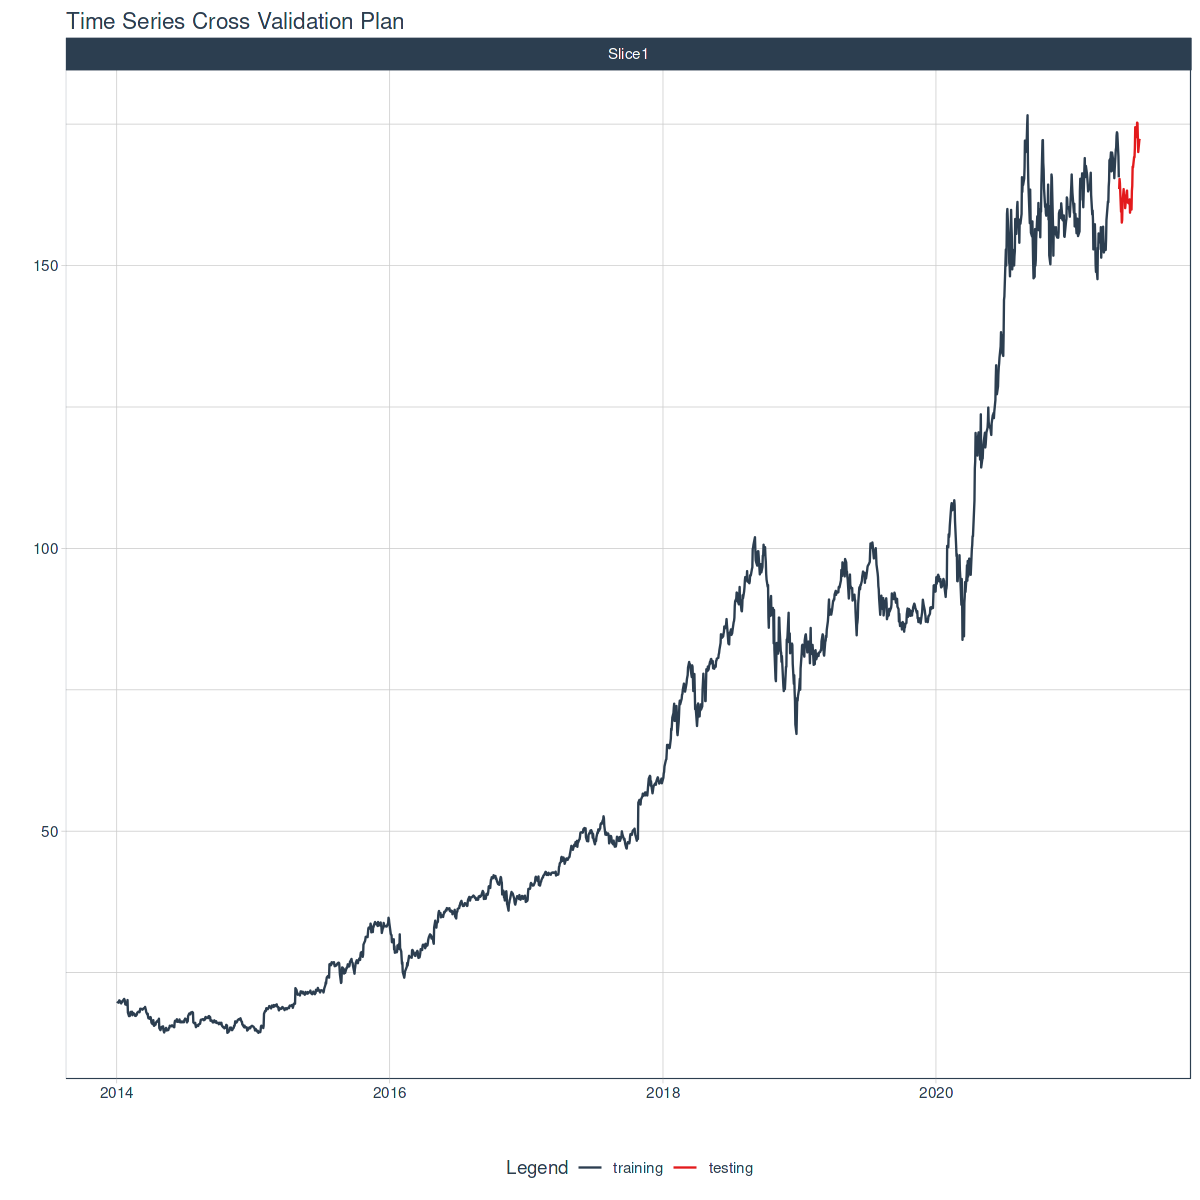

In [69]:
#Podemos graficarlo, agregando una línea de suavizamiento a la tendencia. Podemos optar por hacerla interactiva.
splits %>%
  tk_time_series_cv_plan() %>%
  plot_time_series_cv_plan(Index, Amzn, .interactive = FALSE)

<a id="17"></a> <br>
##### C. Desarrollo del modelo MARS

Como parte de la especificación del desarrollo de modelos en ModeTime, debemos contar con los soguiente elementos:
* a Especificación del Modelo (ejemplo: MARS)
* b Especificaciones
* c Flujo de tarea que contempla:
    * add_recipe(b)
    * add_model(a)
    * fit() que especifica la sección de entrenamiento.

In [70]:
# Model MARS o earth ----
model_spec_mars <- mars(mode = "regression") %>%
    set_engine("earth") 

recipe_spec <- recipe(Amzn ~ Index, data = training(splits)) %>%
  step_timeseries_signature(Index) %>%
  step_rm(contains("am.pm"), contains("hour"), contains("minute"),
          contains("second"), contains("xts")) %>%step_dummy(all_nominal())
recipe_spec %>% prep() %>% juice() %>% head()
  


Index      Amzn    Index_index.num Index_year Index_year.iso Index_half
1 2014-01-02 19.8985 1388620800      2014       2014           1         
2 2014-01-03 19.8220 1388707200      2014       2014           1         
3 2014-01-06 19.6815 1388966400      2014       2014           1         
4 2014-01-07 19.9015 1389052800      2014       2014           1         
5 2014-01-08 20.0960 1389139200      2014       2014           1         
6 2014-01-09 20.0505 1389225600      2014       2014           1         
  Index_quarter Index_month Index_day Index_wday ⋯ Index_month.lbl_08
1 1             1           2         5          ⋯ 0.04307668        
2 1             1           3         6          ⋯ 0.04307668        
3 1             1           6         2          ⋯ 0.04307668        
4 1             1           7         3          ⋯ 0.04307668        
5 1             1           8         4          ⋯ 0.04307668        
6 1             1           9         5          ⋯ 0.04307668        
  Index_month.lbl_09 Index_month.lbl_10 Index_month.lbl_11 Index_wday.lbl_1
1 -0.01721256        0.005456097        -0.001190618        1.889822e-01   
2 -0.01721256        0.005456097        -0.001190618        3.779645e-01   
3 -0.01721256        0.005456097        -0.001190618       -3.779645e-01   
4 -0.01721256        0.005456097        -0.001190618       -1.889822e-01   
5 -0.01721256        0.005456097        -0.001190618        2.098124e-17   
6 -0.01721256        0.005456097        -0.001190618        1.889822e-01   
  Index_wday.lbl_2 Index_wday.lbl_3 Index_wday.lbl_4 Index_wday.lbl_5
1 -3.273268e-01    -4.082483e-01     0.0805823        5.455447e-01   
2  0.000000e+00    -4.082483e-01    -0.5640761       -4.364358e-01   
3  9.690821e-17     4.082483e-01    -0.5640761        4.364358e-01   
4 -3.273268e-01     4.082483e-01     0.0805823       -5.455447e-01   
5 -4.364358e-01     4.532467e-17     0.4834938        5.342065e-16   
6 -3.273268e-01    -4.082483e-01     0.0805823        5.455447e-01   
  Index_wday.lbl_6
1  0.4934638      
2 -0.1973855      
3 -0.1973855      
4  0.4934638      
5 -0.6579517      
6  0.4934638

In [71]:
# Modelo MARS o earth ----
model_spec_mars <- mars(mode = "regression") %>%
    set_engine("earth") 
##Anexamos al workflow:  
wflw_fit_mars <- workflow() %>%
   add_recipe(recipe_spec) %>%
    add_model(model_spec_mars) %>%
    fit(training(splits))

<a id="19"></a> <br>
##### D. Adición del modelo ajustado a ModelTable

El siguiente paso es adicionar cada modelo a un formato tipo Modeltime Table empleando modeltime_table().

Este paso hace algunas revisiones básicas para asegurarse que cada uno de los modelos son en sí ajustados a los datos y con ello, se organiza en una estructura escalable llamada "Modeltime Table", que se usa como parte del proceso de pronóstico.


In [72]:
#Anexamos modelo al modeltime:
models_tbl <- modeltime_table(
    wflw_fit_mars)

<a id="20"></a> <br>
##### E. Proceso de calibración

El proceso de calibración involucra el aplicar el modelo a la serie de prueba.

In [73]:
#Calibramos:
calibration_tbl <- models_tbl %>%
    modeltime_calibrate(new_data = testing(splits))

<a id="21"></a> <br>
##### F. Pronóstico conjunto de prueba & Evaluación de la precisión
* Proceso calibración del modelo con toda la serie.
* Determinación métricos de error pronósticos

In [74]:
##Nueva Calibración del Modelo con toda la serie:
calibration_tbl %>%
    modeltime_forecast(
        new_data    = testing(splits),
        actual_data = Pr_index) %>% tail()

.model_id .model_desc .key       .index     .value   .conf_lo .conf_hi
1 1         EARTH       prediction 2021-06-22 163.9922 153.5066 174.4779
2 1         EARTH       prediction 2021-06-23 164.0068 153.5212 174.4925
3 1         EARTH       prediction 2021-06-24 164.0214 153.5358 174.5071
4 1         EARTH       prediction 2021-06-25 164.0361 153.5504 174.5217
5 1         EARTH       prediction 2021-06-28 164.0799 153.5942 174.5656
6 1         EARTH       prediction 2021-06-29 164.0945 153.6088 174.5802

In [75]:
#Determinación métricos error:
calibration_tbl %>%
    modeltime_accuracy() %>%
    table_modeltime_accuracy(
        .interactive = interactive
    )

HTML widgets cannot be represented in plain text (need html)

<a id="22"></a> <br>
##### G. Pronóstico hacia adelante

Este paso es una de las grandes ventajas de este paquete, donde aplica una función para generar los pronósticos hace adelante. En este caso, aplicamos una ventana de 10 días.

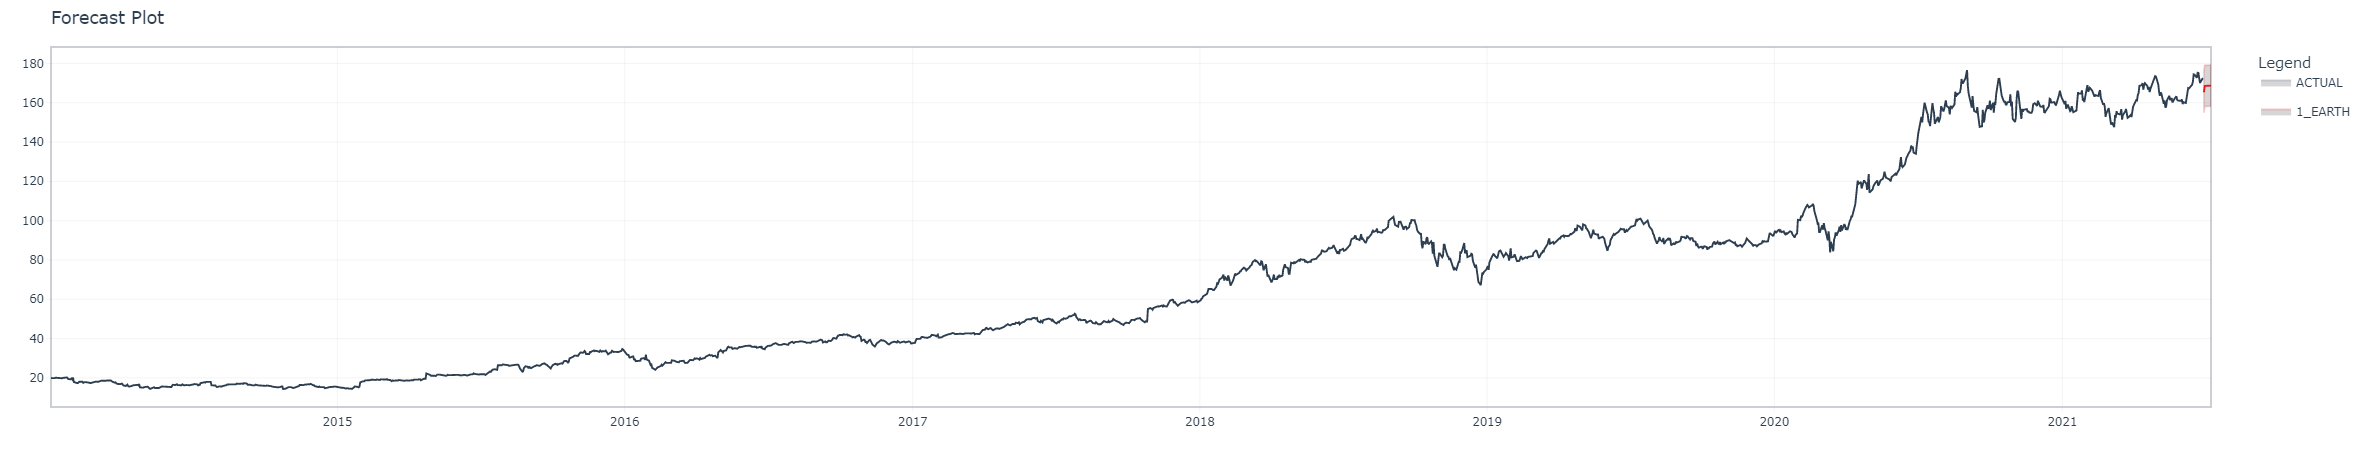

In [76]:
refit_tbl <- calibration_tbl %>%
    modeltime_refit(data = Pr_index)
refit_tbl %>%
    modeltime_forecast(h = "10 days", actual_data = Pr_index) %>%
    plot_modeltime_forecast(
      .legend_max_width = 25, 
      .interactive      = interactive
    )

En este tutorial aprendimos dos metodologías para el desarrollo de modelos de regresión con splines. La parte 1, contempla un proceso manual donde es de nuestro interés el saber qué modelos se desempeñan mejor ante un mismo set de entrenamiento y prueba. Este enfoque, a pesar de ser muy efectivo, requiere de la aplicación del modelo a una secuencialidad, partiendo del último dato hacia atrás, para generar el pronóstico futuro. En las siguientes semanas aprenderemos una manera diferente para generar dicho secuenciamiento para el pronóstico; por el momento y tomando ventaja de las funcionalidades de la paquetería de ModelTime, generamos dicho pronóstico.
Continuemos con los temas de modelos de regresión lineal múltiple, donde generaremos una estructura similar a la aquí descrita, a manera de comaprar dichos modelos de regresión.